In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Import the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Generative Adversarial Network (GAN)

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Generative Adversarial Network (GAN)


In [ ]:
data = pd.read_csv('mnist_train.csv')

# Extracting first 10000 samples for learning purpose

In [ ]:
data = np.array(data)
data = data[0:10000,:]
data.shape

(10000, 785)

# We do not need labels

In [ ]:
data =data[:,1:]

In [ ]:
data.shape

(10000, 784)

## Normalize the data between (-1,1) because we are using tanh function in our Generator Network

In [ ]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler( feature_range=(-1, 1) )
dataN = norm.fit_transform(data)

# Converting to torch tensor

In [ ]:
dataT = torch.tensor( dataN, dtype = torch.float32 )

# GAN Architecture for this Project

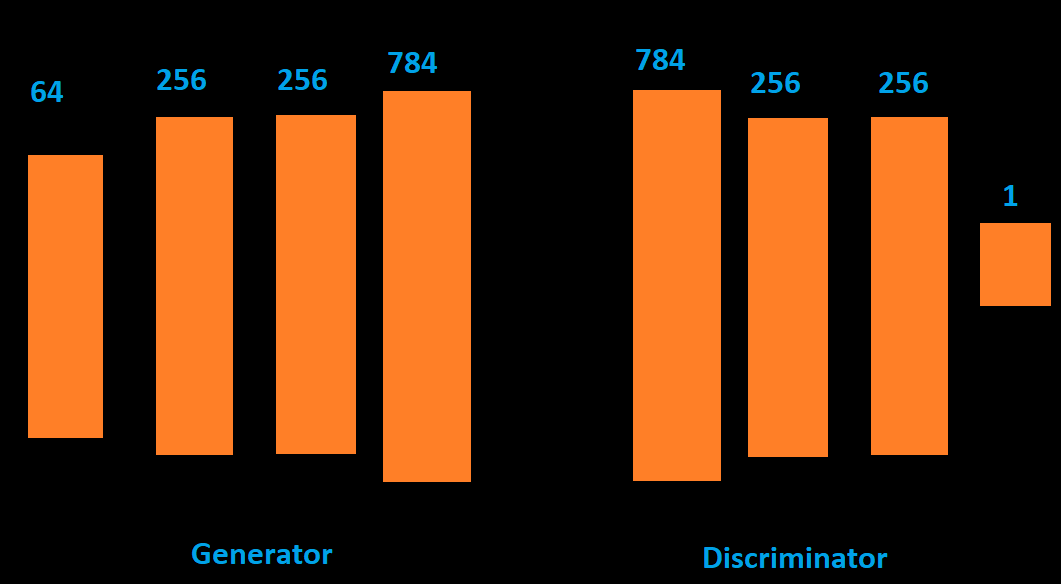

# Create classes for the discriminator and generator

In [ ]:
class discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(784,256) # 28 * 28 = 784
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1) # Last feature =1 , so that we can get probability from the discriminative model
                                                    # whether the image is real or fake.

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x ) # P > 0.5 mean real and less than 0.5 means fake image

In [ ]:
class generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256) # 64 here is just a random selection for generator input
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784) # Here we get 784, which we convert into 28 * 28 image.

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x ) # The reason we normalize the data between (-1,1)

# See what generator is producing without training

In [ ]:
genModel = generator()
ypred = genModel(torch.randn(1,64))

In [ ]:
ypred = ypred.detach().squeeze().view(28,28)

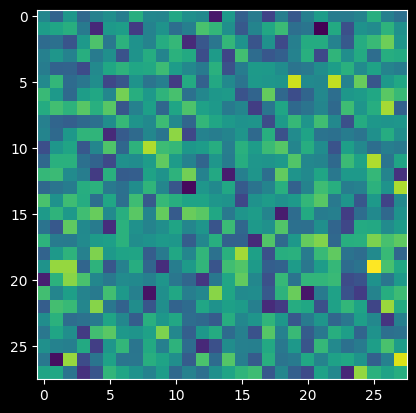

In [ ]:
plt.imshow(ypred);

# Train discriminator and generator

In [ ]:
lossfunc = nn.BCELoss() # For both models

disModel = discriminator().to(device) # Creating Instance of discriminator
genModel = generator().to(device)     # Creating Instance of generator

# We need different optimizers for both models as their parameters are different.

dis_optimizer = torch.optim.Adam(disModel.parameters(), lr=.0005)
gen_optimizer = torch.optim.Adam(genModel.parameters(), lr=.0005)

## First We train the discriminator and then we train the generator.

In [ ]:
epochs = 50001
batchsize = 128
losses  = np.zeros((epochs,2)) # (num_epochs,2) because we have to train two models i.e generator and discriminator.
dis_output = np.zeros((epochs,2)) # dis_output = discriminator decisions

for epoch in range(epochs):

  rand_idx = np.random.choice(dataT.shape[0], size= batchsize)
  real_images = dataT[rand_idx,:].to(device) # Real Images are generated from the real data (dataT)
  fake_images = genModel( torch.randn(batchsize,64).to(device) ) # Fake images are generated from the output of generator
                                                                 # by sending random input number to generator.


  # Creating Labels used for real and fake images

  real_labels = torch.ones(batchsize,1).to(device) # All ones means true because they are real labels
  fake_labels = torch.zeros(batchsize,1).to(device) # All zeros means false because they are fake labels


  # TRAIN THE DISCRIMINATOR

  # Forward pass and loss for REAL Images   (step1 of discriminator training)

  ypred_real   = disModel(real_images)                 # REAL images into discriminator
  dis_loss_real = lossfunc(ypred_real, real_labels)    # All labels are 1. In order to reduce loss model should learn to predict 1
                                                       # for real images

  # In the above step1 of training discriminator, we pass all real images to discriminator
  # and the comparing Ypred_real (predictions of discriminator) with real_labesl(all ones).
  # This is our loss which we have to minimize.



  # Forward pass and loss for FAKE Images (step 2 of discriminator training)

  ypred_fake   = disModel(fake_images)              # FAKE images into discriminator
  dis_loss_fake = lossfunc(ypred_fake, fake_labels)   # All labels are 0. In order to reduce loss model should learn to predict 0
                                                      # for fake images

  # Calculate combined loss.

  dis_loss = dis_loss_real + dis_loss_fake
  losses[epoch,0]  = dis_loss.item()   # loss will be accumulated along the first column
  dis_output[epoch,0] = torch.mean((ypred_real>.5).float()).detach() # This line is storing the model decision.


  # Backpropagation for discriminator

  dis_optimizer.zero_grad()
  dis_loss.backward()
  dis_optimizer.step()




  # TRAIN THE GENERATOR

  # Create the fake images and compute loss

  fake_images = genModel( torch.randn(batchsize,64).to(device) )
  ypred_fake   = disModel(fake_images)

  # In above two lines of code, we generate fake images from the generator
  # and pass the fake images through discriminator to get the predictions.




  # Compute loss and accuracy
  gen_loss = lossfunc(ypred_fake, real_labels)   # Here we comparing the predictions of
                                                 # of discriminator with the real_labels to get the loss of generator
                                                 # In this step we are trying to deceive to discriminator that our images are real. if
                                                 # discriminator accepts this then there is no loss, otherwise we need to train generator
                                                 # more so that it can fool the discriminator.
  losses[epoch,1]  = gen_loss.item()
  dis_output[epoch,1] = torch.mean((ypred_fake>.5).float()).detach()

  # Backpropagation of generator.

  gen_optimizer.zero_grad()
  gen_loss.backward()
  gen_optimizer.step()


  # print out a status message
  if (epoch)%500==0:
    print(f' Epochs : {epoch}/{epochs}')



 Epochs : 0/50001
 Epochs : 500/50001
 Epochs : 1000/50001
 Epochs : 1500/50001
 Epochs : 2000/50001
 Epochs : 2500/50001
 Epochs : 3000/50001
 Epochs : 3500/50001
 Epochs : 4000/50001
 Epochs : 4500/50001
 Epochs : 5000/50001
 Epochs : 5500/50001
 Epochs : 6000/50001
 Epochs : 6500/50001
 Epochs : 7000/50001
 Epochs : 7500/50001
 Epochs : 8000/50001
 Epochs : 8500/50001
 Epochs : 9000/50001
 Epochs : 9500/50001
 Epochs : 10000/50001
 Epochs : 10500/50001
 Epochs : 11000/50001
 Epochs : 11500/50001
 Epochs : 12000/50001
 Epochs : 12500/50001
 Epochs : 13000/50001
 Epochs : 13500/50001
 Epochs : 14000/50001
 Epochs : 14500/50001
 Epochs : 15000/50001
 Epochs : 15500/50001
 Epochs : 16000/50001
 Epochs : 16500/50001
 Epochs : 17000/50001
 Epochs : 17500/50001
 Epochs : 18000/50001
 Epochs : 18500/50001
 Epochs : 19000/50001
 Epochs : 19500/50001
 Epochs : 20000/50001
 Epochs : 20500/50001
 Epochs : 21000/50001
 Epochs : 21500/50001
 Epochs : 22000/50001
 Epochs : 22500/50001
 Epochs : 23

# Visualizing Model Performance

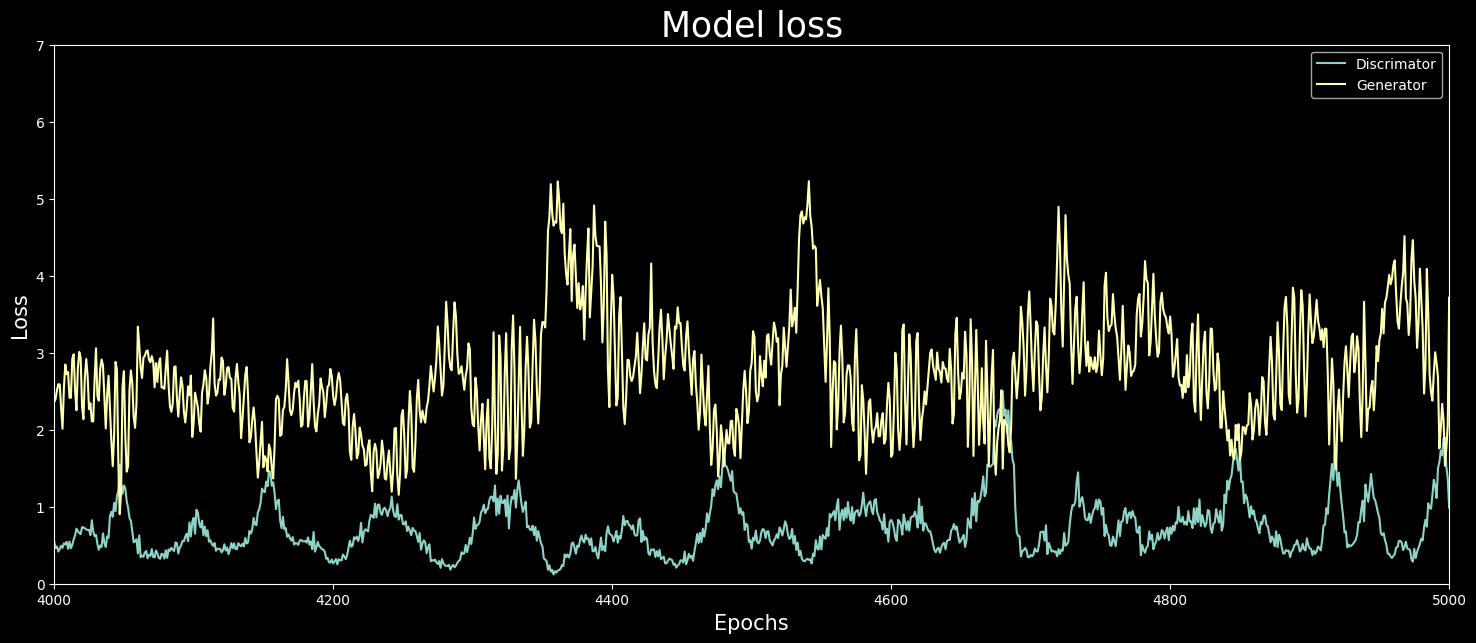

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(losses)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('Model loss', fontsize = 25)
plt.legend(['Discrimator','Generator'])
plt.xlim([4000,5000])
plt.ylim([0,7])
plt.show()


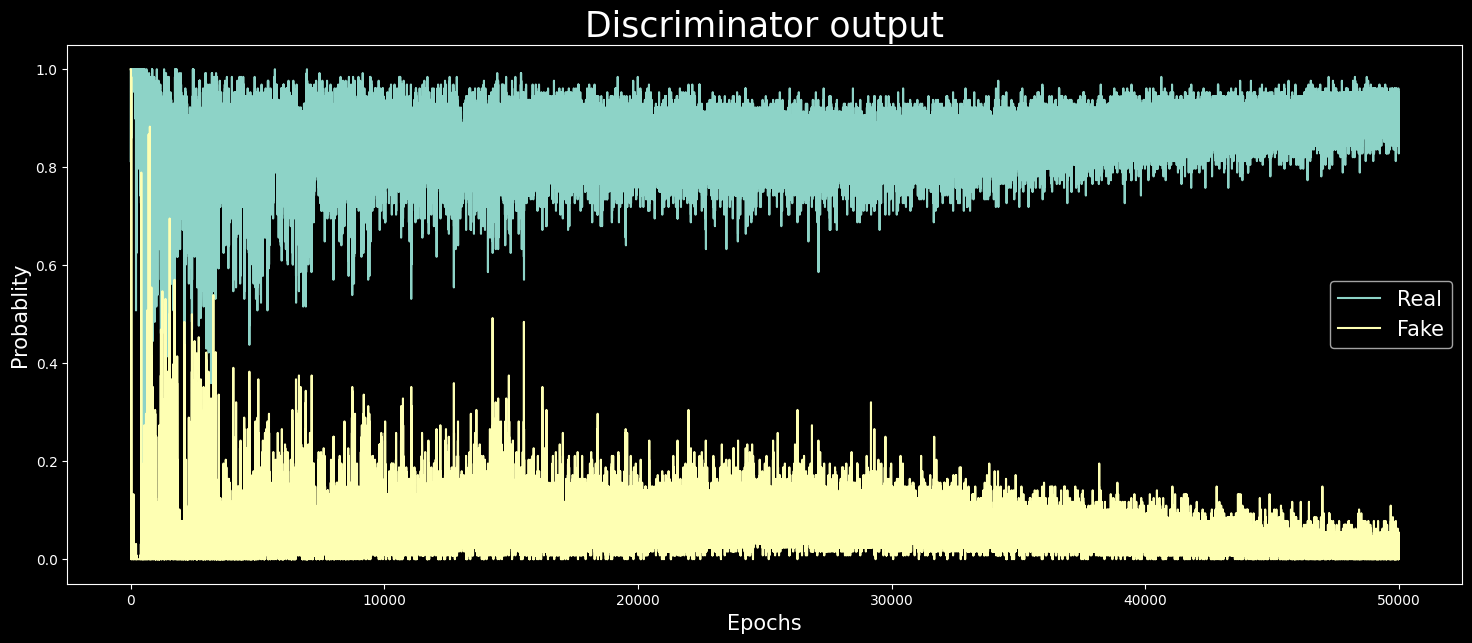

In [ ]:
plt.figure(figsize=(18,7))
plt.plot(dis_output) # This shows the probability with which discriminator predicts that the data is real or fake
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Probablity',fontsize = 15)
plt.title('Discriminator output', fontsize = 25)
plt.legend(['Real','Fake'], fontsize = 15)

plt.show()

# Generate some fake digits

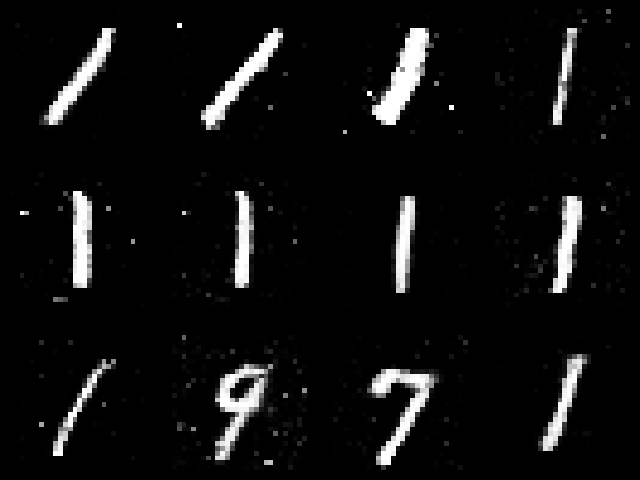

In [ ]:
genModel.eval()
fake_data = genModel(torch.randn(12,64).to(device)).cpu()


fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()

# Get the discriminator probability

In [ ]:
# In the above cell data fake data is generated by Generator. So we can pass this fake data to discriminator to see how it works.

disModel.eval()
guess = disModel(fake_data.to(device)).cpu()


In [ ]:
guess

tensor([[0.0653],
        [0.2131],
        [0.1426],
        [0.2329],
        [0.1308],
        [0.0882],
        [0.0454],
        [0.1198],
        [0.1890],
        [0.1063],
        [0.7886],
        [0.0824]], grad_fn=<ToCopyBackward0>)